# The notebook worked on using a HMM approach to build a model on node level data
#### Author: Ruyi Yang

## Get Data

In [148]:
pwd

'/root/eks-ml-pipeline/notebooks'

In [2]:
!pip install /root/msspackages/dist/msspackages-0.0.5-py3-none-any.whl

Keyring is skipped due to an exception: 'keyring.backends'
Processing /root/msspackages/dist/msspackages-0.0.5-py3-none-any.whl
msspackages is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [3]:
from msspackages import setup_runner
setup_runner(setup_type = 'notebook' , project = 'understanding-eks-data')

b"Hit:1 http://deb.debian.org/debian buster InRelease\nGet:2 http://security.debian.org/debian-security buster/updates InRelease [34.8 kB]\nGet:3 http://deb.debian.org/debian buster-updates InRelease [56.6 kB]\nGet:4 http://security.debian.org/debian-security buster/updates/main amd64 Packages [410 kB]\nFetched 501 kB in 0s (1394 kB/s)\nReading package lists...\nBuilding dependency tree...\nReading state information...\n59 packages can be upgraded. Run 'apt list --upgradable' to see them.\nReading package lists...\nBuilding dependency tree...\nReading state information...\nsudo is already the newest version (1.8.27-1+deb10u4).\n0 upgraded, 0 newly installed, 0 to remove and 59 not upgraded.\nReading package lists...\nBuilding dependency tree...\nReading state information...\ndefault-jre is already the newest version (2:1.11-71).\n0 upgraded, 0 newly installed, 0 to remove and 59 not upgraded.\nReading package lists...\nBuilding dependency tree...\nReading state information...\npython3 

In [4]:
%pip install hmmlearn

Keyring is skipped due to an exception: 'keyring.backends'
Note: you may need to restart the kernel to use updated packages.


In [7]:
from msspackages import Pyspark_data_ingestion
from pyspark import StorageLevel
from pyspark.sql.functions import *
from hmmlearn import hmm,base

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np
# pandas settings 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [28]:
%%time
node_obj = Pyspark_data_ingestion(year = '2022', month = "7", day = "7", hour = "10", filter_column_value ='Node',setup='128gb')
spark_node = node_obj.get_spark()
err, node_data = node_obj.read()

CPU times: user 357 ms, sys: 181 ms, total: 539 ms
Wall time: 907 ms


In [9]:
node_data.show(vertical=True, n = 1)

-RECORD 0---------------------------------------------------
 account_id                          | 346687249423         
 log_group_name                      | /aws/containerins... 
 log_stream_name                     | ip-100-64-19-132.... 
 record_id                           | 49627967497190512... 
 stream_name                         | dp-us-west-2-cont... 
 record_arrival_stream_timestamp     | 2022-07-07 10:06:23  
 record_arrival_stream_epochtime     | 1657188383           
 log_event_timestamp                 | 2022-07-07 10:06:17  
 log_event_epochtime                 | 1657188377000        
 log_event_id                        | 36956535741443506... 
 AutoScalingGroupName                | nk-ndc-asbc-asg-c... 
 CloudWatchMetrics                   | [{"Dimensions":[[... 
 ClusterName                         | nk-ndc-eks-cluste... 
 InstanceId                          | i-0fd528a5b4db63a58  
 InstanceType                        | m5.16xlarge          
 NodeName               

In [10]:
df = node_data.toPandas()

In [13]:
df.ClusterName[0]

'nk-ndc-eks-cluster-test-dev-usw2-az2-perf'

## Preprocess data


<font color='red'>this process won't work for some data, need to further investigate before adding it to the data pipeline </font>

In [36]:
from scipy import stats
from scipy.special import logsumexp
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt

In [37]:
import statistics
from sklearn.preprocessing import QuantileTransformer


df.dropna(subset=['node_cpu_utilization','node_memory_utilization'], how='any', inplace=True)

x_unlabeled = df[['node_cpu_utilization','node_memory_utilization']].values
def data_process(x_unlabeled):
    ## transform data to Gaussia distribution
   
    qt = QuantileTransformer(n_quantiles =len(x_unlabeled),output_distribution='normal',random_state = 42)
    qt.fit_transform(x_unlabeled)


### em process

In [10]:
## initialize all the unknown parameters to ensure the random 
## initialzation of the covariance matrices is positive semi-definite
def get_random_psd(n):
    x = np.random.normal(0, 1, size=(n, n))
    return np.dot(x, x.transpose())


def initialize_random_params():
    params = {'phi': np.random.uniform(0, 1),
              'mu0': np.random.normal(0, 1, size=(2,)),
              'mu1': np.random.normal(0, 1, size=(2,)),
              'sigma0': get_random_psd(2),
              'sigma1': get_random_psd(2)}
    return params

In [11]:
## expectation steps, calculate the heuristics for every data points 
## as well as the average log-likelihoods which we will maximize in the M step
def e_step(x, params):
    np.log([stats.multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),
            stats.multivariate_normal(params["mu1"], params["sigma1"]).pdf(x)])
    log_p_y_x = np.log([1-params["phi"], params["phi"]])[np.newaxis, ...] + \
                np.log([stats.multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),
            stats.multivariate_normal(params["mu1"], params["sigma1"]).pdf(x)]).T
    log_p_y_x_norm = logsumexp(log_p_y_x, axis=1)
    return log_p_y_x_norm, np.exp(log_p_y_x - log_p_y_x_norm[..., np.newaxis])

## maximize step, in which paramenters are updated using the closed-form solutions
def m_step(x, params):
    total_count = x.shape[0]
    _, heuristics = e_step(x, params)
    heuristic0 = heuristics[:, 0]
    heuristic1 = heuristics[:, 1]
    sum_heuristic1 = np.sum(heuristic1)
    sum_heuristic0 = np.sum(heuristic0)
    phi = (sum_heuristic1/total_count)
    mu0 = (heuristic0[..., np.newaxis].T.dot(x)/sum_heuristic0).flatten()
    mu1 = (heuristic1[..., np.newaxis].T.dot(x)/sum_heuristic1).flatten()
    diff0 = x - mu0
    sigma0 = diff0.T.dot(diff0 * heuristic0[..., np.newaxis]) / sum_heuristic0
    diff1 = x - mu1
    sigma1 = diff1.T.dot(diff1 * heuristic1[..., np.newaxis]) / sum_heuristic1
    params = {'phi': phi, 'mu0': mu0, 'mu1': mu1, 'sigma0': sigma0, 'sigma1': sigma1}
    return params

In [119]:
def get_avg_log_likelihood(x, params):
    loglikelihood, _ = e_step(x, params)
    print(loglikelihood)
    return np.mean(loglikelihood)


def run_em(x, params):
    avg_loglikelihoods = []
    while True:
        avg_loglikelihood = get_avg_log_likelihood(x, params)
        avg_loglikelihoods.append(avg_loglikelihood)
        if len(avg_loglikelihoods) > 2 and abs(avg_loglikelihoods[-1] - avg_loglikelihoods[-2]) < 0.0001:
            break
        params = m_step(x_unlabeled, params)
    print("\tphi: %s\n\tmu_0: %s\n\tmu_1: %s\n\tsigma_0: %s\n\tsigma_1: %s"
               % (params['phi'], params['mu0'], params['mu1'], params['sigma0'], params['sigma1']))
    _, posterior = e_step(x_unlabeled, params)
    forecasts = np.argmax(posterior, axis=1)
    return forecasts, posterior, avg_loglikelihoods

In [242]:
## dealling with missing value: since we dont know the pattern of missing data, 
## drop it for now
## we remove the outlier data as well (1std)
import statistics
from sklearn.preprocessing import QuantileTransformer


df.dropna(subset=['node_cpu_utilization','node_memory_utilization'], how='any', inplace=True)

x_unlabeled = df[['node_cpu_utilization','node_memory_utilization']].values
def data_process(x_unlabeled):
    ## transform data to Gaussia distribution
   
    qt = QuantileTransformer(n_quantiles =len(x_unlabeled),output_distribution='normal',random_state = 42)
    qt.fit_transform(x_unlabeled)

    '''
    _data = x_unlabeled.T
    miu1 = statistics.mean(_data[0])
    sigma1 = statistics.stdev(_data[0])
    miu2 = statistics.mean(_data[1])
    sigma2 = statistics.stdev(_data[1])
    x = []
    for i in range(len(x_unlabeled)):
        rec = x_unlabeled[i]
        if (rec[0]>(miu1+2*sigma1)) or (rec[0]<(miu1-2*sigma1)) or \
        (rec[1]>(miu2+2*sigma2)) or (rec[0]<(miu1-2*sigma2)):
            x.append(i)
    x_train = np.delete(x_unlabeled,x,0)
    '''
    return x_unlabeled
    
#from sklearn.preprocessing import normalize
#x_train= normalize(x_train)
                                   
                                   
                                   

In [125]:
learned_params= {
    "phi": 0.05621166454355069,
    "mu0": [-0.02388356 ,-0.03127706],
	"mu1": [0.39704515, 0.51919104],
	"sigma0": [[1.05524666, 0.82555869],
 [0.82555869, 1.03992686]],
	"sigma1": [[ 0.0168586,  -0.04452107],
 [-0.04452107,  0.1237928 ]]
    
}

## Create HMM model

In [254]:
## use only if em algo works
'''
from hmmlearn import hmm

weights = [1 - learned_params["phi"], learned_params["phi"]]
means = [learned_params["mu0"], learned_params["mu1"]]
covariances = [learned_params["sigma0"], learned_params["sigma1"]]

model1 = hmm.GaussianHMM(n_components = 3, covariance_type = "full",\
                         init_params = 't',n_iter = 50, random_state = 42)

model1.startprob_ = weights
model1.means_ = means
model1.covars_ = covariances

#model1 = hmm.GaussianHMM(n_components = 3, covariance_type = "full", n_iter = 50, random_state = 42)


model1.fit(x_unlabeled)
'''

'\nfrom hmmlearn import hmm\n\nweights = [1 - learned_params["phi"], learned_params["phi"]]\nmeans = [learned_params["mu0"], learned_params["mu1"]]\ncovariances = [learned_params["sigma0"], learned_params["sigma1"]]\n\nmodel1 = hmm.GaussianHMM(n_components = 3, covariance_type = "full",                         init_params = \'t\',n_iter = 50, random_state = 42)\n\nmodel1.startprob_ = weights\nmodel1.means_ = means\nmodel1.covars_ = covariances\n\n#model1 = hmm.GaussianHMM(n_components = 3, covariance_type = "full", n_iter = 50, random_state = 42)\n\n\nmodel1.fit(x_unlabeled)\n'

In [38]:
## to detect anomaly, we just first divide the node status to be "not ready" and "ready", by setting n_components = 2
model1 = hmm.GaussianHMM(n_components = 2, covariance_type = "full",\
                         init_params = 'stmc',n_iter = 50, random_state = 42)

## would adjust init_params based on em performance

In [52]:
# split train and test
from sklearn.model_selection import train_test_split
x_train, x_validate = train_test_split(x_unlabeled, shuffle=False, train_size=0.7)

# model fit and predict
model1.fit(x_train)
train_states = model1.predict(x_train)
train_samples = [np.random.multivariate_normal(model1.means_[s], model1.covars_[s]) \
                 for s in train_states]


In [14]:

print(f"the model's stationary distribution is \n {model1.get_stationary_distribution()} ")
print(f"the model's start probability is \n {model1.startprob_} ")
print(f"the model's transition matrix is \n {model1.transmat_} ")
print(f"the model's distribution means is \n {model1.means_}")
print(f"the model's distribution covariance is \n {model1.covars_}")


the model's stationary distribution is 
 [0.61411199 0.38588801] 
the model's start probability is 
 [9.99328838e-01 6.71162173e-04] 
the model's transition matrix is 
 [[0.60610571 0.39389429]
 [0.62685341 0.37314659]] 
the model's distribution means is 
 [[4.87178442 9.81005745]
 [0.40690716 1.85452305]]
the model's distribution covariance is 
 [[[4.32223936e+01 8.76374136e+00]
  [8.76374136e+00 5.90581878e+01]]

 [[5.22411765e-02 1.94683769e-01]
  [1.94683769e-01 1.85871293e+00]]]


In [40]:
artifact_res = model1.predict(train_samples)

In [26]:
x = 0
for i in range(len(artifact_res)):
    if artifact_res[i]!=train_states[i]:
        x+=1

In [27]:
x/len(artifact_res)

0.009710349406589758

In [60]:
#change samples to nparray
train_samples = np.stack(train_samples,axis = 0) 
train_samples[0]

array([11.94275997, 13.01637968])

In [63]:
residual_cpu = x_train.T[0]-train_samples.T[0]
residual_memory = x_train.T[1]-train_samples.T[1]

absolute_error_cpu = np.abs(residual_cpu)
absolute_error_memory = np.abs(residual_memory)

cpu_threshold = np.max(absolute_error_cpu)
memory_threshold = np.max(absolute_error_memory)

In [70]:
print(f"The threshold for cpu is {cpu_threshold }; and the threshold for memory is {memory_threshold}")

The threshold for cpu is 79.51421269039595; and the threshold for memory is 63.39711937309764


### test score

In [71]:
#### calculate score using 30% validation dataset 

valid_states = model1.predict(x_validate)
valid_samples = [np.random.multivariate_normal(model1.means_[s], model1.covars_[s]) \
                 for s in valid_states]
np.power(valid_samples - x_validate, 2).mean()

58.96403618766914

In [109]:
#valid_samples = np.stack(valid_samples,axis = 0) 
residual_cpu_valid = x_validate.T[0] - valid_samples.T[0]
residual_mem_valid = x_validate.T[1] - valid_samples.T[1]
residual_valid = np.stack((residual_cpu_valid.T, residual_mem_valid.T), axis=1)

abs_error_valid_cpu = np.abs(residual_cpi_valid)
abs_error_valid_mem = np.abs(residual_mem_valid)
is_anomaly = np.logical_or((abs_error_valid_cpu > cpu_threshold), (abs_error_valid_mem > memory_threshold)) 


In [189]:
anomalist = is_anomaly.tolist()

In [191]:
np.where(is_anomaly==1)

(array([12957, 13325]),)

In [120]:
x_validate.T.tolist()

[[0.4014538460011078,
  0.20426828462946728,
  3.438832691266595,
  0.9993814770915453,
  4.879891273777128,
  0.3984290078270618,
  0.35673506428350943,
  0.4574744131712761,
  0.36937462674961813,
  8.101640953096656,
  0.3998032966490588,
  0.5113791793479266,
  0.8483611515019702,
  2.9432450955399947,
  7.754632432853664,
  0.31526558932819393,
  9.864564244784074,
  0.348068567212741,
  8.534708947786084,
  24.71045421017651,
  0.36188892362032976,
  0.5720863610428163,
  0.36316096878497484,
  1.6798025499386051,
  0.9331903311580511,
  0.3435972091816031,
  3.296921260622385,
  7.801116189986549,
  2.0723305521337587,
  11.273503624657831,
  10.403419167964527,
  0.16170702077213606,
  0.1988613360204095,
  0.41742678084493906,
  5.579447311357503,
  0.2274975335009432,
  0.9273353847977523,
  0.39886012866437714,
  0.37824914836218837,
  0.16907413041272978,
  2.4442130809398397,
  7.3990860596707435,
  0.37689253513059195,
  3.2604922968640313,
  3.1669114882564435,
  2.63396

In [121]:
x_performance = pd.DataFrame(x_validate, columns = ['Cpu_utilizaiton','Mem_utilization'])

In [124]:
valid_samples

array([[ 2.64444192e+00,  1.13384747e+01],
       [ 5.53143993e-01,  1.77887640e+00],
       [ 1.16676549e+01,  1.32595960e+01],
       ...,
       [ 6.88247756e+00,  1.90419117e+01],
       [ 2.01529145e-01, -1.34835419e-02],
       [ 1.35019009e+01,  4.72875475e+00]])

In [125]:
x_performance['prediction_cpu'] = valid_samples.T[0]
x_performance['prediction_mem'] = valid_samples.T[1]
x_performance['anomaly'] = is_anomaly
x_performance['residual_cpu'] = abs_error_valid_cpu
x_performance['residual_mem'] = abs_error_valid_mem

In [143]:
x_performance.head()


,Cpu_utilizaiton,Mem_utilization,prediction_cpu,prediction_mem,anomaly,redidual_cpu,redidual_mem
0,0.401454,6.722414,2.644442,11.338475,False,2.242988,4.616061
1,0.204268,1.076857,0.553144,1.778876,False,0.348876,0.702020
2,3.438833,5.650841,11.667655,13.259596,False,8.228822,7.608755
3,0.999381,5.775148,0.633221,2.228038,False,0.366161,3.547110
4,4.879891,12.266857,6.489257,1.278340,False,1.609365,10.988516


In [148]:
x_performance.reset_index(inplace = True)


In [149]:
x_performance.head()

,index,Cpu_utilizaiton,Mem_utilization,prediction_cpu,prediction_mem,anomaly,redidual_cpu,redidual_mem
0,0,0.401454,6.722414,2.644442,11.338475,False,2.242988,4.616061
1,1,0.204268,1.076857,0.553144,1.778876,False,0.348876,0.702020
2,2,3.438833,5.650841,11.667655,13.259596,False,8.228822,7.608755
3,3,0.999381,5.775148,0.633221,2.228038,False,0.366161,3.547110
4,4,4.879891,12.266857,6.489257,1.278340,False,1.609365,10.988516


In [180]:
subdf.anomaly.sum()

0

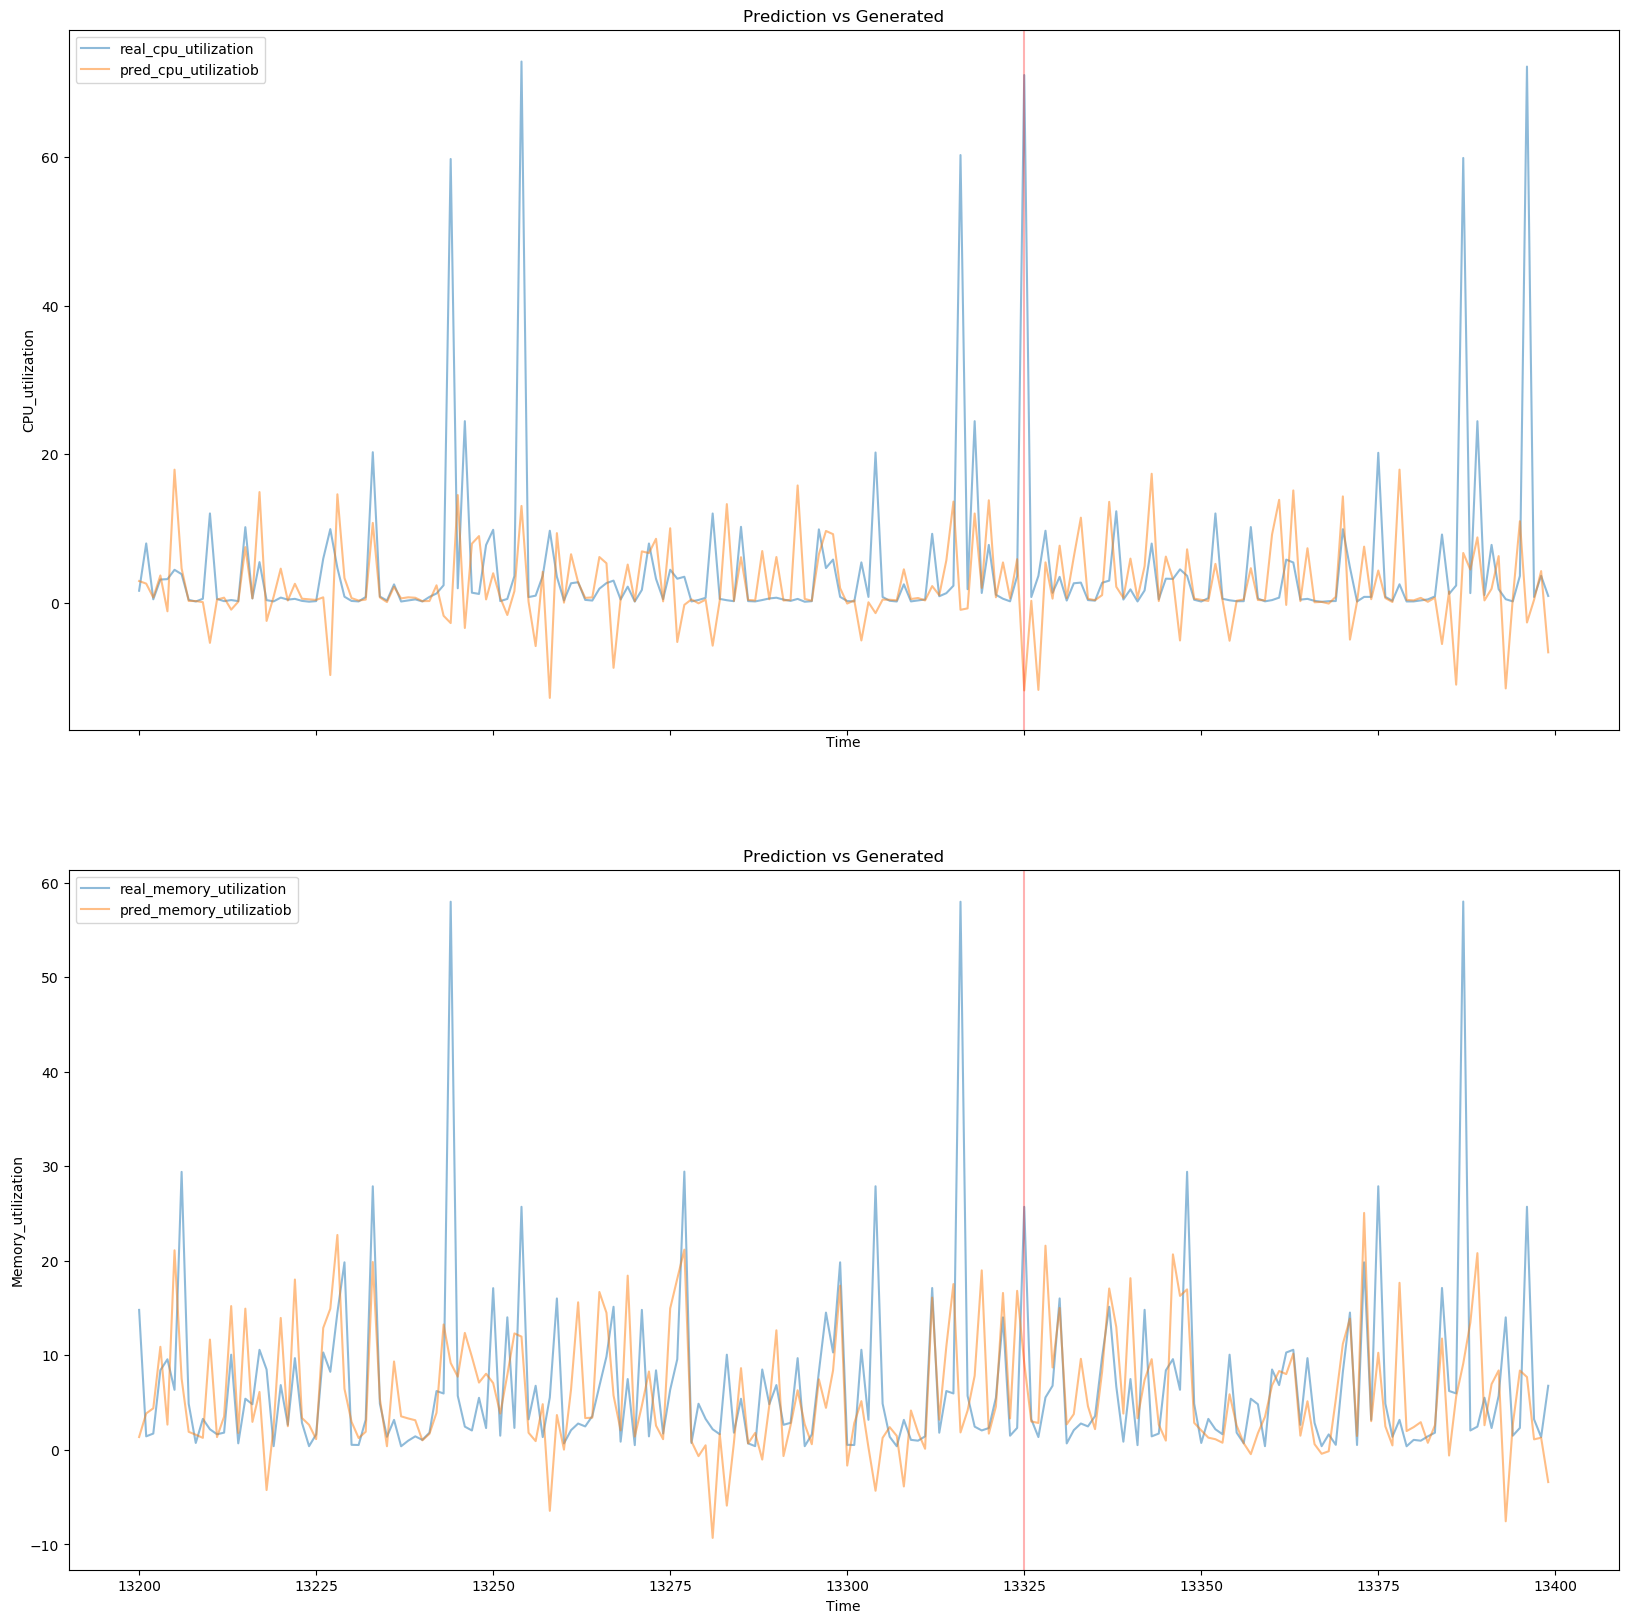

In [195]:
fig,ax = plt.subplots(2,1,figsize=(20,20),sharex = True)
subdf = x_performance[13200:13400]
ax[0].plot(subdf.index,subdf.Cpu_utilizaiton,alpha = 0.5)
ax[0].plot(subdf.index,subdf.prediction_cpu,alpha = 0.5)
ax[0].axvline(x = 13325, color = 'r', label = 'anomaly',alpha = 0.3)
ax[0].legend(['real_cpu_utilization','pred_cpu_utilizatiob'])
ax[0].set_title('Prediction vs Generated')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('CPU_utilization')
ax[1].plot(subdf.index,subdf.Mem_utilization	,alpha = 0.5)
ax[1].plot(subdf.index,subdf.prediction_mem,alpha = 0.5)
ax[1].legend(['real_memory_utilization','pred_memory_utilizatiob'])
ax[1].axvline(x = 13325, color = 'r', label = 'anomaly',alpha = 0.3)
ax[1].set_title('Prediction vs Generated')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Memory_utilization')
plt.show()

## On what level should I conduct my research model? Will model trained on a single node perform the same on others? on same cluster level? compared with all other nodes?

In [180]:
df.groupby(by=['ClusterName','NodeName']).count().sort_values(by = 'account_id',ascending = False).head(n = 10)

account_id  \
ClusterName                                 NodeName                                                  
nk-rdc-eks-cluster-cicdtest-rdc-uw2-az2-std ip-100-64-22-21.us-west-2.compute.internal          218   
                                            ip-100-64-10-69.us-west-2.compute.internal          216   
                                            ip-100-64-10-88.us-west-2.compute.internal          215   
oracle-ndc-eks-cluster-dev-use1-geo01       ip-172-24-56-71.ec2.internal                         62   
nk-bedc-eks-cluster-sbox-usw2-az2-std-sbox  ip-100-66-29-27.us-west-2.compute.internal           61   
cs-ndc-eks-cluster-dev-sdnc-eks             ip-172-24-28-148.ec2.internal                        61   
oracle-ndc-eks-cluster-dev-use1-geo01       ip-172-24-56-98.ec2.internal                         61   
nk-ndc-eks-cluster-dev-use1-04              ip-172-24-69-222.ec2.internal                        61   
mv-ndc-eks-cluster-dev-smsc-usw2-01         ip-172-16-71-226.us-west-2.compute.internal          61   
                                            ip-172-16-71-227.us-west-2.compute.internal          61   

                                                                                         log_group_name  \
ClusterName                                 NodeName                                                      
nk-rdc-eks-cluster-cicdtest-rdc-uw2-az2-std ip-100-64-22-21.us-west-2.compute.internal              218   
                                            ip-100-64-10-69.us-west-2.compute.internal              216   
                                            ip-100-64-10-88.us-west-2.compute.internal              215   
oracle-ndc-eks-cluster-dev-use1-geo01       ip-172-24-56-71.ec2.internal                             62   
nk-bedc-eks-cluster-sbox-usw2-az2-std-sbox  ip-100-66-29-27.us-west-2.compute.internal               61   
cs-ndc-eks-cluster-dev-sdnc-eks             ip-172-24-28-148.ec2.internal                            61   
oracle-ndc-eks-cluster-dev-use1-geo01       ip-172-24-56-98.ec2.internal                             61   
nk-ndc-eks-cluster-dev-use1-04              ip-172-24-69-222.ec2.internal                            61   
mv-ndc-eks-cluster-dev-smsc-usw2-01         ip-172-16-71-226.us-west-2.compute.internal              61   
                                            ip-172-16-71-227.us-west-2.compute.internal              61   

                                                                                         log_stream_name  \
ClusterName                                 NodeName                                                       
nk-rdc-eks-cluster-cicdtest-rdc-uw2-az2-std ip-100-64-22-21.us-west-2.compute.internal               218   
                                            ip-100-64-10-69.us-west-2.compute.internal               216   
                                            ip-100-64-10-88.us-west-2.compute.internal               215   
oracle-ndc-eks-cluster-dev-use1-geo01       ip-172-24-56-71.ec2.internal                              62   
nk-bedc-eks-cluster-sbox-usw2-az2-std-sbox  ip-100-66-29-27.us-west-2.compute.internal                61   
cs-ndc-eks-cluster-dev-sdnc-eks             ip-172-24-28-148.ec2.internal                             61   
oracle-ndc-eks-cluster-dev-use1-geo01       ip-172-24-56-98.ec2.internal                              61   
nk-ndc-eks-cluster-dev-use1-04              ip-172-24-69-222.ec2.internal                             61   
mv-ndc-eks-cluster-dev-smsc-usw2-01         ip-172-16-71-226.us-west-2.compute.internal               61   
                                            ip-172-16-71-227.us-west-2.compute.internal               61   

                                                                                         record_id  \
ClusterName                                 NodeName                                                 
nk-rdc-eks-cluster-cicdtest-rdc-uw2-az2-std ip-100-64-22-21.us-wes

In [209]:
learned_params= {
    "phi": 0.05621166454355069,
    "mu0": [-0.02388356 ,-0.03127706],
	"mu1": [0.39704515, 0.51919104],
	"sigma0": [[1.05524666, 0.82555869],
 [0.82555869, 1.03992686]],
	"sigma1": [[ 0.0168586,  -0.04452107],
 [-0.04452107,  0.1237928 ]]}

In [245]:
## target node selectiom
_df = df[df.NodeName =='ip-100-64-22-21.us-west-2.compute.internal']
sub_x = _df[['node_memory_utilization','node_cpu_utilization']].values
sub_x =data_process(sub_x)

In [246]:
(len(_df),len(sub_x))

(277, 277)

In [ ]:
## data clean

In [247]:

node_model = hmm.GaussianHMM(n_components=3, covariance_type="tied")
#node_model.mean_
node_model.fit(sub_x)

GaussianHMM(algorithm='viterbi', covariance_type='tied', covars_prior=0.01,
            covars_weight=1, implementation='log', init_params='stmc',
            means_prior=0, means_weight=0, min_covar=0.001, n_components=3,
            n_iter=10, params='stmc', random_state=None, startprob_prior=1.0,
            tol=0.01, transmat_prior=1.0, verbose=False)

In [248]:
node_model.fit(sub_x)

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


GaussianHMM(algorithm='viterbi', covariance_type='tied', covars_prior=0.01,
            covars_weight=1, implementation='log', init_params='stmc',
            means_prior=0, means_weight=0, min_covar=0.001, n_components=3,
            n_iter=10, params='stmc', random_state=None, startprob_prior=1.0,
            tol=0.01, transmat_prior=1.0, verbose=False)

In [251]:
node_model.score(sub_x[200:])

-32082.49438209649

In [234]:
len(sub_x)

47

## Process update:
Instead of using the whole data to train my model, I decided to build each model for similar nodes. To do this, I need to first get an insight into the individual node performance inside cluster.

In [121]:
import datetime
df['Timestamp'] = pd.to_numeric(df.Timestamp)
datetime.datetime.fromtimestamp(df.Timestamp )  


TypeError: cannot convert the series to <class 'int'>

In [124]:
df['Timestamp'][0]
import time

time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(1657188368827))
            

'54484-03-16 22:27:07'

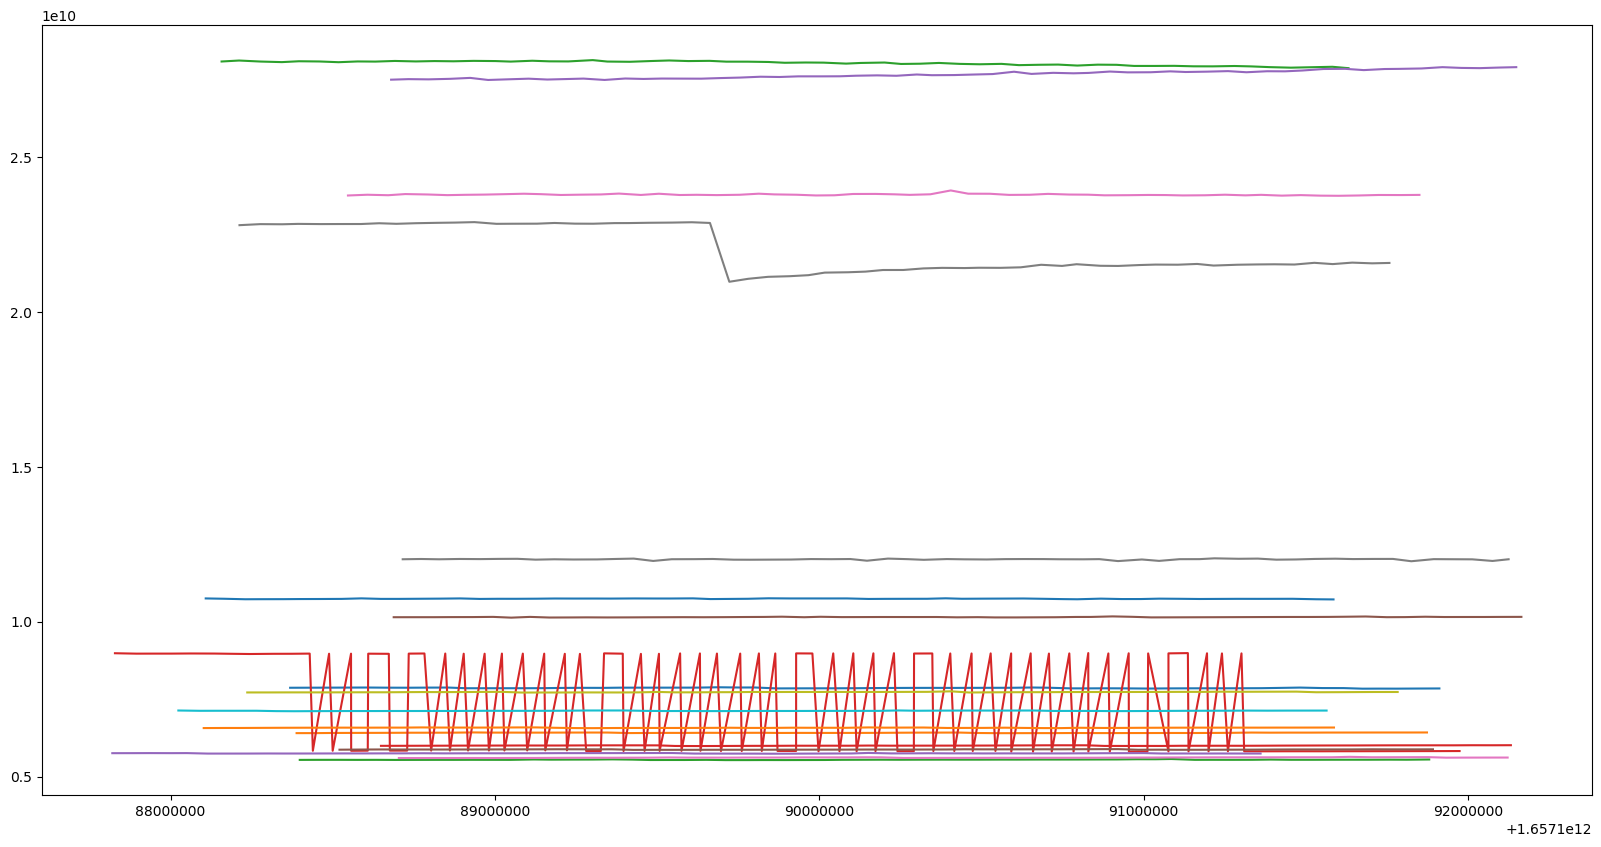

In [76]:
fig,ax = plt.subplots(figsize = (20,10))
for node in df[df.ClusterName==df.ClusterName[0]].NodeName.unique():
    subdf = df[df.NodeName ==node]
    subdf = subdf.sort_values(by='Timestamp')
    plt.plot(subdf.Timestamp,subdf.node_memory_usage)

plt.show()

for nodename = ip-100-64-19-132.us-west-2.compute.internal:
     differences = 0.00799791358775992
mean = 1.788386940621887
std = 0.0013338598810172
for nodename = ip-100-64-27-114.us-west-2.compute.internal:
     differences = 0.0037561547820699204
mean = 1.120210279030894
std = 0.0007345617968733584
for nodename = ip-100-64-31-88.us-west-2.compute.internal:
     differences = 0.0056204453080808126
mean = 1.0700489645963758
std = 0.0011034251717501047
for nodename = ip-100-64-11-41.us-west-2.compute.internal:
     differences = 0.0033146829135775047
mean = 1.074797726803566
std = 0.0007937260180621089
for nodename = ip-100-64-20-220.us-west-2.compute.internal:
     differences = 0.007686943187775963
mean = 1.070327513361451
std = 0.0014094151641727791
for nodename = ip-100-64-22-35.us-west-2.compute.internal:
     differences = 0.0023470617921454995
mean = 1.1669803251613247
std = 0.0005941638844303778
for nodename = ip-100-64-27-36.us-west-2.compute.internal:
     differences = 0.029

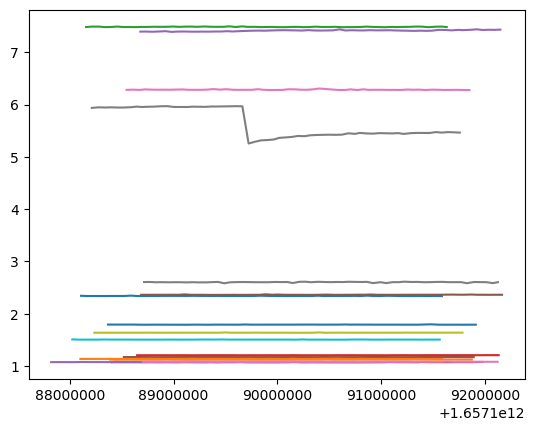

In [118]:
### memory
cluster_data = df[df.ClusterName==df.ClusterName[0]]
for i in range(len(cluster_data.NodeName.unique())):
    node_data = cluster_data[cluster_data.NodeName==cluster_data.NodeName.unique()[i]]
    node_data = node_data.sort_values(by='Timestamp')
    print(f"for nodename = {cluster_data.NodeName.unique()[i]}:\n \
    differences = {node_data.node_memory_utilization.max()-node_data.node_memory_utilization.min()}")
    print(f"mean = {node_data.node_memory_utilization.mean()}")
    print(f"std = {node_data.node_memory_utilization.std()}")

    plt.plot(node_data.Timestamp,node_data.node_memory_utilization)
plt.show()

for nodename = ip-100-64-19-132.us-west-2.compute.internal:
     differences = 0.20764748814008216
mean = 0.9824941301833007
std = 0.04783686087385712
for nodename = ip-100-64-27-114.us-west-2.compute.internal:
     differences = 0.04555815147297759
mean = 0.25077145406319457
std = 0.010220770921331493
for nodename = ip-100-64-31-88.us-west-2.compute.internal:
     differences = 0.05910697928452882
mean = 0.1920669147753326
std = 0.011264278787445679
for nodename = ip-100-64-11-41.us-west-2.compute.internal:
     differences = 0.043409578090554096
mean = 0.21577691436564167
std = 0.008817186704841483
for nodename = ip-100-64-20-220.us-west-2.compute.internal:
     differences = 0.040568210349190115
mean = 0.1986454919011804
std = 0.008709268338819916
for nodename = ip-100-64-22-35.us-west-2.compute.internal:
     differences = 0.036360130282572956
mean = 0.2124411674743984
std = 0.007259169044191551
for nodename = ip-100-64-27-36.us-west-2.compute.internal:
     differences = 0.3263573

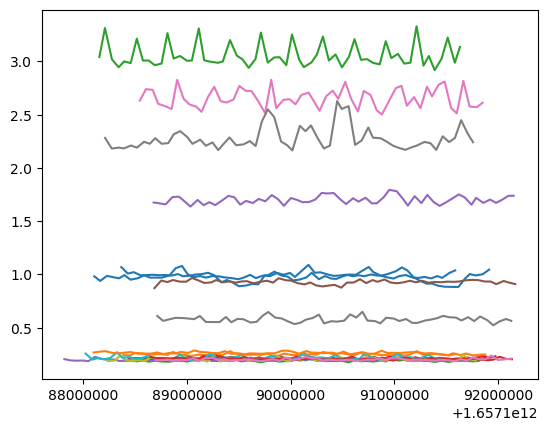

In [120]:
### cpu
for i in range(len(cluster_data.NodeName.unique())):
    node_data = cluster_data[cluster_data.NodeName==cluster_data.NodeName.unique()[i]]
    node_data = node_data.sort_values(by='Timestamp')
    print(f"for nodename = {cluster_data.NodeName.unique()[i]}:\n \
    differences = {node_data.node_cpu_utilization.max()-node_data.node_cpu_utilization.min()}")
    print(f"mean = {node_data.node_cpu_utilization.mean()}")
    print(f"std = {node_data.node_cpu_utilization.std()}")

    plt.plot(node_data.Timestamp,node_data.node_cpu_utilization)
plt.show()

except one of the case which we have a sudden drop in the memory usage, it usually does not change much. Therefore it should be approachable to build a individual model inside each model if appropriately normalize the data. From the cpu graph we could also find that the peak of nodes in the same cluster happens approximately at the same time, autoscailing(?) 

# build model based on cluster-level data

In [8]:
%%time
node_obj = Pyspark_data_ingestion(year = '2022', month = "7", day = "7", hour = -1, filter_column_value ='Node',setup='128gb')
spark_node = node_obj.get_spark()
err, node_data = node_obj.read()

CPU times: user 28.7 ms, sys: 15 ms, total: 43.7 ms
Wall time: 11.3 s


In [9]:
node_data = node_data.toPandas()

## Preprocess data by removing missing and outliers and scaling the data

In [10]:
node_data = node_data[node_data.ClusterName =='nk-ndc-eks-cluster-test-dev-usw2-az2-perf']

In [11]:
node_data = node_data[['Timestamp','node_cpu_utilization','node_memory_utilization','NodeName']]

In [12]:
node_data['Timestamp'] = pd.to_numeric(node_data['Timestamp'])
node_data.sort_values(by = 'Timestamp',inplace = True)

In [13]:
node_data.head()

,Timestamp,node_cpu_utilization,node_memory_utilization,NodeName
892711,1657151816623,0.211553,1.064920,ip-100-64-20-220.us-west-2.compute.internal
892768,1657151875653,0.199940,1.064766,ip-100-64-20-220.us-west-2.compute.internal
892825,1657151943186,0.201840,1.064534,ip-100-64-20-220.us-west-2.compute.internal
892884,1657151988229,0.188688,1.063736,ip-100-64-20-220.us-west-2.compute.internal
910319,1657152031939,0.246508,1.495235,ip-100-64-9-154.us-west-2.compute.internal


In [ ]:
## data preprocessing idea:
### each node have a different resource utilization base line. Therefore I will use the standard
### scalar to transform the data to ensure that the resource usage are on the same level. 
### Followed by it should be a normal distribui

In [24]:
params_dict = {}

for nodename in node_data.NodeName.unique():
    subdf = node_data[node_data.NodeName == nodename]
    miu_cpu = subdf.node_cpu_utilization.mean()
    miu_mem = subdf.node_memory_utilization.mean()
    sigma_cpu = subdf.node_cpu_utilization.std()
    sigma_mem = subdf.node_memory_utilization.std()
    params_dict[nodename]=[miu_cpu,miu_mem,sigma_cpu,sigma_mem]
    
for i in range(len(node_data)):
    nodename = node_data.iloc[i]['NodeName']
    params = params_dict[nodename]
    node_data.iloc[i]['node_cpu_utilization'] = (node_data.iloc[i]['node_cpu_utilization']-params[0])/params[2]
    node_data.iloc[i]['node_memory_utilization'] = (node_data.iloc[i]['node_memory_utilization']-params[1])/params[3]

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


In [42]:
#epoch time process
import datetime  
node_data.Timestamp = int(node_data.Timestamp /1000)
node_data.Timestamp = node_data['Timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x) ) 

In [46]:
node_data.sort_values(by = ['NodeName','Timestamp'])[:50]

,Timestamp,node_cpu_utilization,node_memory_utilization,NodeName
924127,2022-07-07 00:08:54.040,0.590636,2.599716,ip-100-64-0-112.us-west-2.compute.internal
924290,2022-07-07 00:09:43.107,0.586620,2.595206,ip-100-64-0-112.us-west-2.compute.internal
924453,2022-07-07 00:10:42.497,0.615744,2.596232,ip-100-64-0-112.us-west-2.compute.internal
924610,2022-07-07 00:11:49.223,0.631302,2.602029,ip-100-64-0-112.us-west-2.compute.internal
924775,2022-07-07 00:12:56.134,0.631804,2.601211,ip-100-64-0-112.us-west-2.compute.internal
924940,2022-07-07 00:13:51.907,0.591868,2.603139,ip-100-64-0-112.us-west-2.compute.internal
925102,2022-07-07 00:14:45.712,0.623210,2.597744,ip-100-64-0-112.us-west-2.compute.internal
925263,2022-07-07 00:15:47.578,0.576006,2.602255,ip-100-64-0-112.us-west-2.compute.internal
925424,2022-07-07 00:16:56.406,0.632986,2.598417,ip-100-64-0-112.us-west-2.compute.internal
925586,2022-07-07 00:17:52.486,0.569630,2.601877,ip-100-64-0-112.us-west-2.compute.internal


 The record frequency for each node is given at approximately 1 record/minute, no need to group by time interval for now.

#### Model design:
Train: one node/whole day/remove outlier <br/>
Test: other nodes/whole day

In [61]:
## find the node which does not have failed through out the day

cluster_obj = Pyspark_data_ingestion(year = '2022', month = "7", day = "7", hour = -1, filter_column_value ='Cluster',setup='128gb')
spark_cluster = cluster_obj.get_spark()
err, cluster_data = cluster_obj.read()

cluster_data = cluster_data.toPandas()

In [73]:
cluster_data.loc[cluster_data.ClusterName == 'nk-ndc-eks-cluster-test-dev-usw2-az2-perf']['cluster_failed_node_count'].sum()

0

no node failed in the cluster we selected, a healthy dataset to train

In [67]:
## Train data
train_df = node_data.loc[node_data.NodeName == 'ip-100-64-0-112.us-west-2.compute.internal']
#train_df.node_cpu_utilization.quantile(0.1)

0.5480385131720137

In [104]:
x_train = node_data[['node_cpu_utilization','node_memory_utilization']].values

In [101]:
from hmmlearn.hmm import GaussianHMM
import random

## a grid search on parameter
for i in range(2,10):
    for j in range(10):
        scores = []
        model = hmm.GaussianHMM(n_components=i, covariance_type="full",random_state = j)
        model.fit(x_train)
        scores.append(model.score(x_train))
        print(f"the state number is {i} and score is {model.score(x_train)}")

the state number is 2 and score is -34387.43204980916
the state number is 2 and score is -34387.43204980735
the state number is 2 and score is -34387.43204978976
the state number is 2 and score is -34387.432049792966
the state number is 2 and score is -34387.432049786796
the state number is 2 and score is -37484.563069591815
the state number is 2 and score is -12857.808743348669
the state number is 2 and score is -37482.72892302239
the state number is 2 and score is -34387.43204978848
the state number is 2 and score is -44812.4700121143
the state number is 3 and score is -31001.39029321209
the state number is 3 and score is 3462.484145440024
the state number is 3 and score is 3462.2380326252796
the state number is 3 and score is -33434.96946259068
the state number is 3 and score is -33649.758194290785
the state number is 3 and score is -26548.878577592317
the state number is 3 and score is 3185.469872101928
the state number is 3 and score is -3193.501504270156
the state number is 3 and

The model performs on avergae the best when there are 9 hidden states

In [137]:
model = hmm.GaussianHMM(n_components=9, covariance_type="full",random_state = 123)
model.fit(x_train)

GaussianHMM(algorithm='viterbi', covariance_type='full', covars_prior=0.01,
            covars_weight=1, implementation='log', init_params='stmc',
            means_prior=0, means_weight=0, min_covar=0.001, n_components=9,
            n_iter=10, params='stmc', random_state=123, startprob_prior=1.0,
            tol=0.01, transmat_prior=1.0, verbose=False)

In [138]:
node_data.head()

,Timestamp,node_cpu_utilization,node_memory_utilization,NodeName
892711,2022-07-06 23:56:56.623,0.211553,1.064920,ip-100-64-20-220.us-west-2.compute.internal
892768,2022-07-06 23:57:55.653,0.199940,1.064766,ip-100-64-20-220.us-west-2.compute.internal
892825,2022-07-06 23:59:03.186,0.201840,1.064534,ip-100-64-20-220.us-west-2.compute.internal
892884,2022-07-06 23:59:48.229,0.188688,1.063736,ip-100-64-20-220.us-west-2.compute.internal
910319,2022-07-07 00:00:31.939,0.246508,1.495235,ip-100-64-9-154.us-west-2.compute.internal


In [139]:
for nodename in node_data.NodeName.unique():
    subdf = node_data[node_data.NodeName == nodename]
    x_test = subdf[['node_cpu_utilization','node_memory_utilization']].values
    print(f"Node is {nodename}, score is {model.score(x_test)}")

Node is ip-100-64-20-220.us-west-2.compute.internal, score is 4815.037826596285
Node is ip-100-64-9-154.us-west-2.compute.internal, score is -2335.042229729558
Node is ip-100-64-9-238.us-west-2.compute.internal, score is -3971.0754118883474
Node is ip-100-64-6-223.us-west-2.compute.internal, score is 3806.0733862308084
Node is ip-100-64-21-197.us-west-2.compute.internal, score is -3109.582206358882
Node is ip-100-64-11-79.us-west-2.compute.internal, score is -4827.279173813221
Node is ip-100-64-24-0.us-west-2.compute.internal, score is -2962.7401743349947
Node is ip-100-64-19-132.us-west-2.compute.internal, score is -2647.6730299831834
Node is ip-100-64-27-114.us-west-2.compute.internal, score is 4056.2083831919185
Node is ip-100-64-31-88.us-west-2.compute.internal, score is 4466.002264280556
Node is ip-100-64-22-35.us-west-2.compute.internal, score is 4534.337847515205
Node is ip-100-64-27-36.us-west-2.compute.internal, score is -5195.352862572799
Node is ip-100-64-11-41.us-west-2.com

the model fits overall good on most of the models, therefore should better define a hmm model for each cluster

In [140]:
model.get_stationary_distribution()

array([0.07214659, 0.0939739 , 0.08748733, 0.03432241, 0.05052687,
       0.42086467, 0.14721467, 0.02299037, 0.07047318])

In [141]:
model.startprob_

array([1.72089582e-153, 7.88381742e-013, 1.10025061e-066, 4.47922026e-003,
       0.00000000e+000, 9.95520453e-001, 3.26898683e-007, 2.41352378e-010,
       1.89383578e-024])

In [142]:
### fit the model on a random node to see its predict
subdf = node_data[node_data.NodeName == 'ip-100-64-9-154.us-west-2.compute.internal']
x_test_good = subdf[['node_cpu_utilization','node_memory_utilization']].values
y_pred = model.predict(x_test_good)

In [143]:
np.unique(y_pred)

array([1, 3, 8])

#### most of the nodes will not have all of the 9 hidden status, 9 may be overfitting?

## Research methodology Update
Change my model building from time series cluster (hierarchical forecasting) to one model for every independent node. Will check the mean squared error as well.

In [208]:
# split data

x= node_data[['node_cpu_utilization','node_memory_utilization']].values
x_train,x_test = x[:int(len(x)*0.7)],x[int(len(x)*0.3)+1:]


In [178]:
def calc_mean(scores):
    x = 0
    for i in scores:
        x+=i
    return x/10
def calc_std(scores):
    x = 0
    mean = calc_mean(scores)
    for i in scores:
        x+=np.power(i-mean,2)
    return np.sqrt(x/10)

In [179]:
# fit model
## a grid search on parameter
for i in range(2,10):
    scores = []
    mean_sqs = []
    for j in range(10):
        
        model = hmm.GaussianHMM(n_components=i, covariance_type="full",random_state = j)
        model.fit(x_train)
        scores.append(model.score(x_train))
        train_states = model.predict(x_train)
        train_samples = [np.random.multivariate_normal(model.means_[s], model.covars_[s]) \
                 for s in train_states]
        mean_sq =  np.power(train_samples - x_train, 2).mean()
        mean_sqs.append(mean_sq)
    print(f"the state number is {i} \n",
    f"and mean score is {calc_mean(scores)},mean square eror is {calc_mean(mean_sqs)} \n",
    f"and std score is {calc_std(scores)},std square eror is {calc_std(mean_sqs)} \n",    )

the state number is 2 
 and mean score is -10137.649111369328,mean square eror is 0.9229503385790572 
 and mean score is 2127.762209589944,mean square eror is 0.6831467087468464 

the state number is 3 
 and mean score is -4270.080237545697,mean square eror is 0.5396764676037618 
 and mean score is 4289.309984619114,mean square eror is 0.5158563837619271 

the state number is 4 
 and mean score is -2215.3648900086746,mean square eror is 0.8603311308110333 
 and mean score is 4349.387870181522,mean square eror is 0.8407145282663733 

the state number is 5 
 and mean score is -135.6409743639846,mean square eror is 0.9616211902346794 
 and mean score is 3203.5832082450015,mean square eror is 0.8042374872528157 

the state number is 6 
 and mean score is 1633.4053555496207,mean square eror is 0.3876089961291197 
 and mean score is 2848.3160851038856,mean square eror is 0.25109329892517085 

the state number is 7 
 and mean score is 2409.7178635582636,mean square eror is 0.27132989471136687

mean log likelihood increases as we increase the hidden state number, while the mean square error is inconstant. The standard deviation shows a decreasing trend as number of hidden status increases.

In [203]:
model = hmm.GaussianHMM(n_components=2, covariance_type="full")
model.fit(x_train)

test_pred = model.predict(x_test)


In [204]:
test_utilization = [np.random.multivariate_normal(model.means_[s], model.covars_[s]) for s in test_pred]

In [234]:
mean_sq_test =  np.power(test_utilization - x_test, 2).mean()
print(f"mse for train is 0.33528750291417525 , mse for test is {mean_sq_test} ")

mse for train is 0.33528750291417525 , mse for test is 0.38259009648650405 


In [209]:
print(f"{model.score(x_train)},{model.score(x_test)}"}

-582.3948296293588,-1674.8842223919514


In [210]:
len(x_train)

18114

In [216]:
state_x = model.predict(x)
train_utilization = [np.random.multivariate_normal(model.means_[s], model.covars_[s]) for s in state_x]

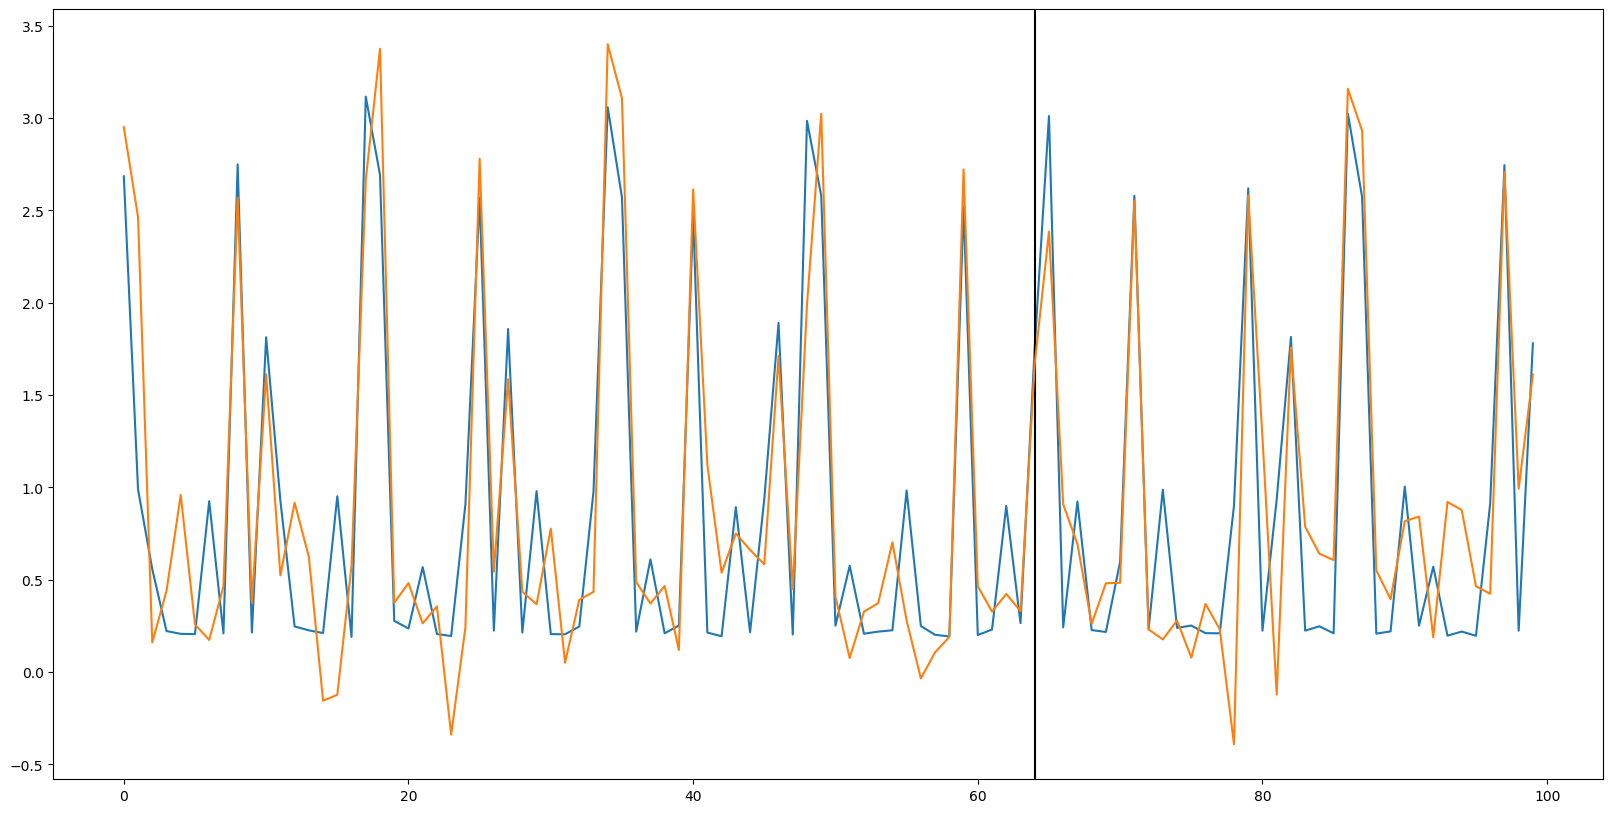

In [233]:
fig,ax = plt.subplots(figsize = (20,10))
x_present = x[18050:18150]

plt.plot(x_present.T[0])
plt.axvline(x=64,color = 'black')
plt.plot(np.array(train_utilization).T[0][18050:18150])
plt.show()